In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



data\BB_Rates_15min_from_10-2023.xlsx


In [12]:
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import torch.nn as nn
import pandas as pd
import numpy as np
from matplotlib import pyplot
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns 
file_path = 'data\BB_Rates_15min_from_10-2023.xlsx'
data = pd.read_excel(file_path)


In [4]:
start_index = 3
EURUSD = data.iloc[start_index:, :2]

# Rename the columns
EURUSD.columns = ['Dates', 'Close']

# Display the first few rows of the new dataset to verify
print(EURUSD.tail())

                     Dates   Close
13539  2024-04-17 09:30:00  1.0632
13540  2024-04-17 09:45:00  1.0625
13541  2024-04-17 10:00:00   1.063
13542  2024-04-17 10:15:00  1.0642
13543  2024-04-17 10:30:00  1.0647


In [5]:
# Convertiere 'Dates' spalte zu Datetime format
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])
time_interval = pd.Timedelta(minutes=15)
# Calculate the difference between consecutive dates
EURUSD['TimeDiff'] = EURUSD['Dates'].diff()

# Identify the sections with consecutive 15-minute intervals
EURUSD['IsConsecutive'] = EURUSD['TimeDiff'] == time_interval
EURUSD['Block'] = (EURUSD['IsConsecutive'] != EURUSD['IsConsecutive'].shift()).cumsum()

In [6]:
# Filter out sections with fewer than 2 days of consecutive 15-minute observations
min_consecutive_minutes = 2 * 24 * 60  # 2 days in minutes
valid_blocks = EURUSD.groupby('Block').filter(lambda x: len(x) >= min_consecutive_minutes / 15).Block.unique()
EURUSD_filtered = EURUSD[EURUSD['Block'].isin(valid_blocks)]

# Add the observation timeframe column
EURUSD_filtered['TimeFrame'] = EURUSD_filtered.groupby('Block').cumcount() + 1

# Drop the 'TimeDiff' and 'IsConsecutive' columns as they are no longer needed
EURUSD_filtered = EURUSD_filtered.drop(columns=['TimeDiff', 'IsConsecutive'])

# Display the first few rows of the filtered dataset with the new 'Block' and 'TimeFrame' columns
print(EURUSD_filtered.head())

                Dates   Close  Block  TimeFrame
4 2023-10-03 23:15:00  1.0466      2          1
5 2023-10-03 23:30:00  1.0465      2          2
6 2023-10-03 23:45:00  1.0465      2          3
7 2023-10-04 00:00:00  1.0468      2          4
8 2023-10-04 00:15:00  1.0467      2          5


C:\Users\nilsw\AppData\Local\Temp\ipykernel_9156\2151116645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EURUSD_filtered['TimeFrame'] = EURUSD_filtered.groupby('Block').cumcount() + 1


In [7]:
block_mapping = {old_block: new_block for new_block, old_block in enumerate(EURUSD_filtered['Block'].unique(), 1)}

In [8]:
EURUSD_filtered = EURUSD_filtered.reset_index(drop=True)
EURUSD_filtered = EURUSD_filtered.drop(columns=['TimeFrame'])
EURUSD_filtered.head()

,Dates,Close,Block
0,2023-10-03 23:15:00,1.0466,2
1,2023-10-03 23:30:00,1.0465,2
2,2023-10-03 23:45:00,1.0465,2
3,2023-10-04 00:00:00,1.0468,2
4,2023-10-04 00:15:00,1.0467,2


In [9]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(lookback, forecast_horizon, data):
        X, Y = [], []
        scaler = MinMaxScaler()
        for i in range(len(data) - lookback - forecast_horizon + 1):
            if data.iloc[i]['Block'] == data.iloc[i + lookback + forecast_horizon - 1]['Block']:
                X_values = data.iloc[i:i+lookback]['Close'].values
                Y_values = data.iloc[i+lookback:i+lookback+forecast_horizon]['Close'].values
                X_scaled = scaler.fit_transform(X_values.reshape(-1, 1))
                Y_scaled = scaler.transform(Y_values.reshape(-1, 1))
                X.append(X_scaled)
                Y.append(Y_scaled)
        return np.array(X), np.array(Y)
X, Y = create_dataset(lookback=96, forecast_horizon=4, data=EURUSD_filtered)

In [10]:
X, Y = create_dataset(lookback=96, forecast_horizon=4, data=EURUSD_filtered)

In [13]:
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

dataset = TensorDataset(X, Y)

C:\Users\nilsw\AppData\Local\Temp\ipykernel_9156\878115574.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
C:\Users\nilsw\AppData\Local\Temp\ipykernel_9156\878115574.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


In [15]:
train_size = int(0.8*len(dataset))
val_size = int(len(dataset)*0.1)
print(train_size)


6315


In [16]:
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = Y[:train_size], Y[train_size:train_size + val_size], Y[train_size + val_size:]

In [17]:
X_train.size(0)
y_train.size(0)

6315

In [18]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [63]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

In [64]:
single = next(iter(train_loader))
print(single[0].shape)

torch.Size([32, 96, 1])


In [29]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # werden als MSE über alle elemente und batch summiert
    mse_loss = nn.MSELoss(reduction = 'sum')(recon_x, x)

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = 1/2*torch.sum(1+logvar -mu.pow(2) - logvar.exp())

    total_loss = mse_loss - kld_loss

    return total_loss, mse_loss, kld_loss

In [57]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        _, (h_n, c_n) = self.lstm(x)
        # h_n: (num_layers, batch_size, hidden_size)
        # c_n: (num_layers, batch_size, hidden_size)
        return h_n, c_n
        
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DecoderLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h_n, c_n):
        # x: (batch_size, seq_len, input_size)
        # h_n: (num_layers, batch_size, hidden_size)
        # c_n: (num_layers, batch_size, hidden_size)
        output, _ = self.lstm(x, (h_n, c_n))
        # output: (batch_size, seq_len, hidden_size)
        output = self.fc(output)
        # output: (batch_size, seq_len, output_size)
        return output
class VAE_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_space_dim, num_layers):
        super(VAE_LSTM, self).__init__()
        
        self.encoder = EncoderLSTM(input_size, hidden_size, num_layers)
        
        self.mu_layer = nn.Linear(hidden_size, latent_space_dim)
        self.logvar_layer = nn.Linear(hidden_size, latent_space_dim)
        
        self.z_layer = nn.Linear(latent_space_dim, hidden_size)
        
        self.decoder = DecoderLSTM(latent_space_dim, hidden_size, num_layers, input_size)
            
    def forward(self, x):
        h_n, c_n = self.encoder(x)
        
        mu = self.mu_layer(h_n[-1])  # Verwende den letzten hidden state als Eingabe für mu und logvar
        logvar = self.logvar_layer(h_n[-1])
        
        if self.training:
            sigma = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(sigma)
            z = mu + epsilon * sigma
        else:
            z = mu
        
        z = self.z_layer(z)
        z = z.unsqueeze(1).repeat(1, x.size(1), 1)  # Wiederhole z für jede Zeitschritt
        output = self.decoder(z, h_n, c_n)
        
        return output, mu, logvar

In [27]:
import time
import numpy as np
import torch
import fastprogress

# TODO Train and test the model
import time
import fastprogress

def train(train_loader, optimizer, model, loss_fn, master_bar):
    
    total_loss = 0
    mse_loss = 0
    kl_loss = 0.
    
    for data in fastprogress.progress_bar(train_loader, parent=master_bar):
        model.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        
        
        pred, mu, logval = model(inputs)
        #print(pred.size(), labels.size())
        
        t_loss, m_loss, k_loss   = loss_fn(pred, inputs, mu, logval)
        t_loss.backward()
        optimizer.step()
        
        total_loss += t_loss.item()
        mse_loss += m_loss.item()
        kl_loss += k_loss.item()
        
    return total_loss, mse_loss, kl_loss
            
        #print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {total_loss/len(dataloader.dataset):.4f}, Reconstruction Loss: {mse_loss / len(dataloader.dataset):.4f}, KL Divergence Loss: {kl_loss / len(dataloader.dataset):.4f}")
        
        
def run_training(model, optimizer, loss_function, num_epochs, 
                train_dataloader, test_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    total_losses, mse_losses, kl_losses = [],[],[]
    test_total_losses, test_mse_losses, test_kl_losses = [],[],[]

    for epoch in master_bar:
        # Train the model
        total_loss, mse_loss, kl_loss = train(train_dataloader, optimizer, model, 
                                                  loss_function, master_bar)
        # Validate the model
#        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
 #                                                                  model, loss_function, 
  #                                                                 device, master_bar)
        test_total_loss, test_mse_loss, test_kl_loss = test_set_loss(test_dataloader, model, loss_function, master_bar)

        # Save loss and acc for plotting
        total_losses.append(total_loss)
        mse_losses.append(mse_loss)
        kl_losses.append(kl_loss)
        
        
        test_total_losses.append(test_total_loss)
        test_mse_losses.append(test_mse_loss)
        test_kl_losses.append(test_kl_loss)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            ####################
            ## YOUR CODE HERE ##
            ####################
            #raise NotImplementedError # Comment out this keyword after your implementation
            early_stopper(epoch_val_loss, model)
            if early_stopper.early_stop:
                break
            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return total_losses, mse_losses, kl_losses, test_total_losses, test_mse_losses, test_kl_losses

def test_set_loss(test_dataloader, model, loss_function, master_bar):
    
    total_loss = 0
    mse_loss = 0
    kl_loss = 0.
    
    with torch.no_grad():
        
        for data in fastprogress.progress_bar(train_loader, parent=master_bar):
            model.eval()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            pred, mu, logval = model(inputs)
            #print(pred.size(), labels.size())

            t_loss, m_loss, k_loss = loss_function(pred, inputs, mu, logval)

            total_loss += t_loss.item()
            mse_loss += m_loss.item()
            kl_loss += k_loss.item()

    return total_loss, mse_loss, kl_loss
    



In [73]:
learning_rate= 0.001
input_size = 1
hidden_size = 96
latent_space_dim = 96
num_layers = 4
epochs = 20


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_LSTM(input_size,hidden_size, latent_space_dim, num_layers)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [74]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
total_losses, mse_losses, kl_losses, test_total_losses, test_mse_losses, test_kl_losses = run_training(
        model, torch.optim.Adam(model.parameters(), lr=learning_rate), vae_loss, epochs, train_loader, test_loader)


KeyboardInterrupt: 

In [33]:
import matplotlib.pyplot as plt

In [70]:

def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Test "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'test results']
    
    if extra_pt:
        
        #raise NotImplementedError # Comment out this keyword after your implementation
        plt.scatter(extra_pt[0], extra_pt[1], color="k", s=50, zorder=4)
        plt.text(extra_pt[0], extra_pt[1], extra_pt_label)

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

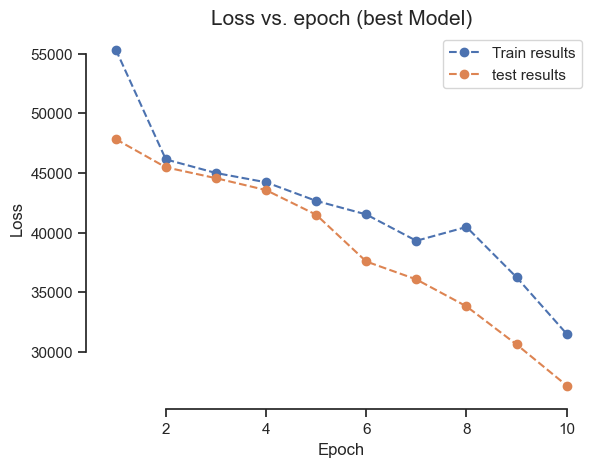

[47824.50776672363, 45462.70534515381, 44553.099197387695, 43553.59075164795, 41491.889739990234, 37570.62504577637, 36069.18711853027, 33812.481773376465, 30617.88501739502, 27178.675804138184]


In [71]:
best_loss = None
plot("Loss vs. epoch (best Model)", "Loss", total_losses, test_total_losses, yscale='linear', extra_pt=best_loss, extra_pt_label="best loss")
print(test_total_losses)

torch.Size([1, 96, 1])
[1.002853   1.0014725  0.9925788  0.9996689  1.0140198  0.99538773
 0.9739624  0.97458744 1.0005327  1.0047271  0.97893965 0.9749674
 0.9997557  1.0016177  1.0033426  0.9885386  0.9708263  1.0082291
 1.0110079  1.0087713  0.99703056 1.0063603  0.9964103  1.0012172
 0.9949841  0.98635364 0.99603826 0.9961775  1.0078201  0.9933629
 0.9981625  0.98625696 0.98670286 1.0082804  0.99382347 0.97693807
 0.9481889  0.9982897  0.94576705 0.99316764 0.9916659  0.99726516
 1.0028191  0.99106216 1.0009143  0.9964118  0.9847934  0.9927634
 0.99118143 0.97345096 0.99715704 1.0034412  0.9924065  0.9992641
 0.9826666  1.0121806  0.99288005 1.0073754  1.0034821  0.9945756
 1.0054753  0.9983177  0.99138767 0.9769959  1.0103713  1.0136825
 1.0038186  0.97921896 0.99286306 0.9921124  0.9902203  1.0003207
 1.0016801  0.9913847  0.9952966  1.0108548  0.9880853  0.98405576
 1.0001762  0.9993151  0.9926159  0.98960406 0.9994588  0.9994555
 0.987993   0.98599344 1.0038     1.0149782  1.00

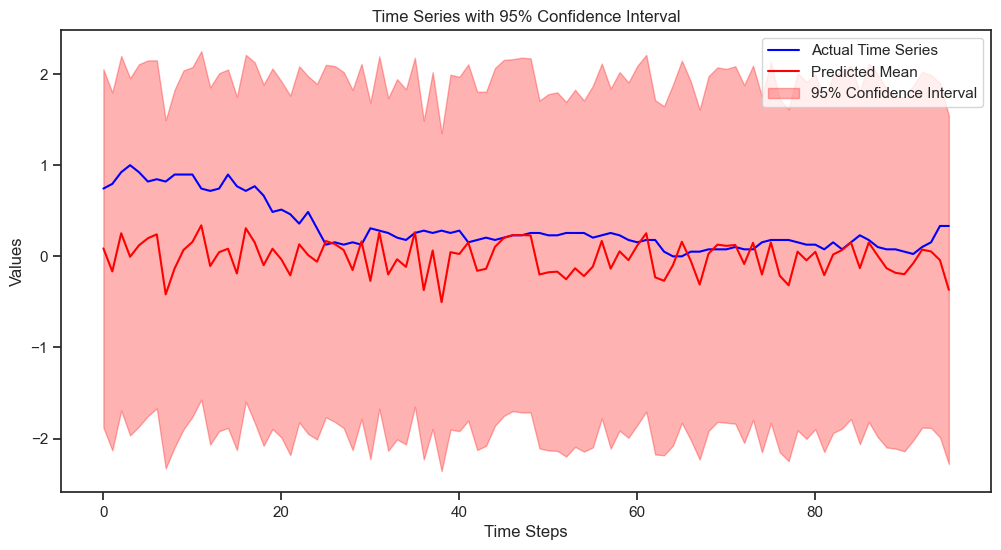

In [72]:
single_batch = next(iter(test_loader))
single_time_series_batch = single_batch[0].to(device)  # Annahme: single_batch ist eine Liste oder ein Tuple
single_time_series = single_time_series_batch[0]  # Annahme: single_time_series_batch ist ein 3D-Tensor
single_time_series = single_time_series.unsqueeze(0)  # Füge eine zusätzliche Dimension für den Batch hinzu
print(single_time_series.size())
# Modell in den Evaluierungsmodus setzen
model.eval()

with torch.no_grad():
    output, pred_mu, pred_logvar = model(single_time_series)  
    pred_mu = pred_mu.squeeze(0).cpu().numpy()
    pred_var = torch.exp(pred_logvar).squeeze(0).cpu().numpy()

# Berechne die Standardabweichung und das Konfidenzintervall
pred_sigma = np.sqrt(pred_var)
print(pred_sigma)
lower_bound = pred_mu - 1.96 * pred_sigma
upper_bound = pred_mu + 1.96 * pred_sigma

# Plotten der Zeitreihe und des Konfidenzintervalls
time_steps = np.arange(len(actual_time_series))
actual_time_series = single_time_series.cpu().numpy()
actual_time_series = actual_time_series.squeeze(0)
plt.figure(figsize=(12, 6))
plt.plot(time_steps, actual_time_series, label='Actual Time Series', color='blue')
plt.plot(time_steps, pred_mu, label='Predicted Mean', color='red')
plt.fill_between(time_steps, lower_bound, upper_bound, color='red', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Time Series with 95% Confidence Interval')
plt.legend()
plt.show()